In [5]:
import htke.load_data
import htke.process_ir_data
#from htke.load_data import *
#from htke.process_ir_data import *

### Load Raw Data

In [2]:
# Instantiate class
Data()

# Load data to dataframe
ir_data = Data.read()

# Visualise the data
#Data.plot(ir_data)

#ir_data

### Find the Peaks in the Raw Data

In [3]:
# Instantiate class - doesn't work as Peaks(ir_data), I have to use Peaks = Peaks(ir_data), why?
Peaks = Peaks(ir_data)

,prominences,peak_heights,Experimental Area,Fitted Area
0,-0.998233,-0.998419,-0.999064,-0.994618
1,-0.994728,-0.994768,-0.997964,-0.998519
2,-0.997984,-0.997953,-0.999745,-0.993446
3,-0.998309,-0.997940,-0.999282,-0.997623
Sum,-3.989255,-3.989080,-3.996055,-3.984206


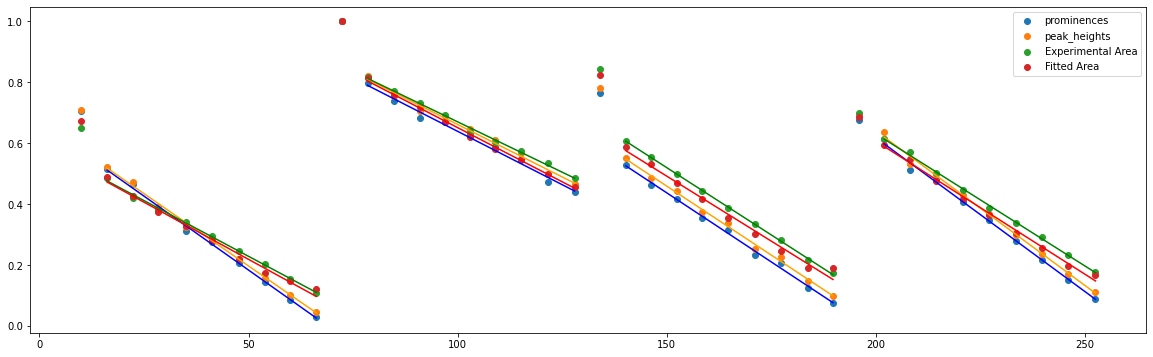

In [4]:
# Determine the peak prominences of every wavelength
#processed_ir_data = Peaks.prominence_all(0.032)

# Determine the peak prominences of a single wavelength
#processed_ir_data = Peaks.prominence(0.032,'Peak at 1704 cm-1')

# Determine the peak heights of a single wavelength - TO TEST
#processed_ir_data = Peaks.height(0.0505,'Peak at 1704 cm-1')

# Determine the experimental areas of each peak - must be only one wavelength
#processed_ir_data = Peaks.exp_area(0.032, 4, 'Peak at 1704 cm-1')

# Determine the experimental areas of each peak - must be only one wavelength
#processed_ir_data = Peaks.fitted_area(0.032, 4, 'Peak at 1704 cm-1')

# Fit a gaussian to a single peak and determine it's area - must be only one wavelength
#processed_ir_data= Peaks.fitted_area_sp(0.05, 4, 'Peak at 1704 cm-1', 0.7, -.4, 2)

# Compare prominence, height, experimental area, and fitted area
r2 = Peaks.compare(0.0505, 0.032, 4,'Peak at 1704 cm-1', 4, 10, 0.7, 0.7)

# Visualise which peaks have been picked - single peak
#Peaks.plot(processed_ir_data, 'Peak at 1704 cm-1')

#processed_ir_data
r2

,prominences,peak_heights,Experimental Area,Fitted Area
0,-0.998233,-0.998419,-0.999180,-0.998589
1,-0.994728,-0.994768,-0.998234,-0.998520
2,-0.997984,-0.997953,-0.999879,-0.998843
3,-0.998309,-0.997940,-0.999509,-0.998323
Sum,-3.989255,-3.989080,-3.996801,-3.994274


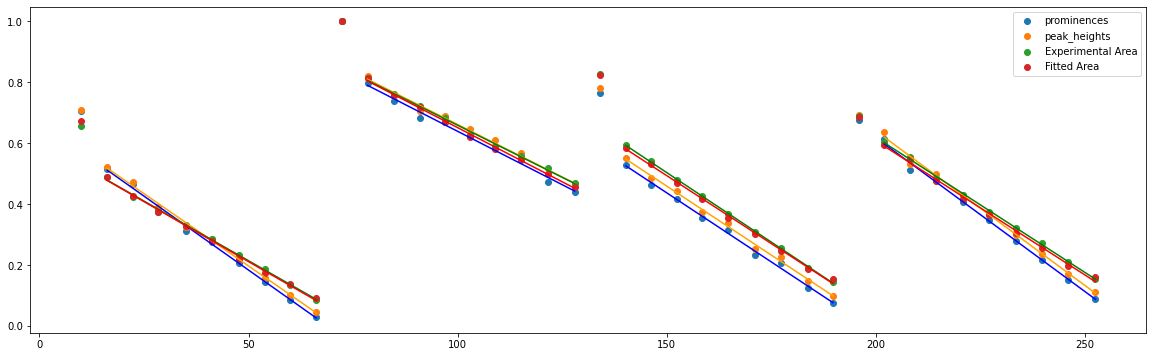

In [8]:
# Change the variables does slightly change the r2 of the areas
r2 = Peaks.compare(0.0505, 0.032, 4,'Peak at 1704 cm-1', 4, 10, 0.7, -0.4)
r2

In [224]:
# Trying to automatically find the best variables for fitting the area
# For loop overkill, patched together to see if it works, will fix later
def test_function(variables):

    peak_threshold = 0.032
    residence_time = variables[0]
    peak_of_interest = 'Peak at 1704 cm-1'
    time_adjust_before = 0.7#variables[1]
    time_adjust_after = 0.7#variables[2]

    # Requires prominence data (don't use prominence function as don't want returned processed_ir_data)
    # Find single peak
    x = ir_data[peak_of_interest]

    # Find peak height and position
    peaks = find_peaks(x, prominence = peak_threshold)
    peak_prominence = peaks[1]
    peak_pos = ir_data['Relative Time'][peaks[0]]

    # Make it a list
    list_of_peaks = list(peak_pos)

    df = []

    for var in list_of_peaks:

        # Find a single peak
        single_peak = ir_data.loc[(ir_data['Relative Time'] >= var - (residence_time/2 - time_adjust_before)) 
                                & (ir_data['Relative Time'] <= var + (residence_time/2 + time_adjust_after))]

        # Find peak area of the experimental data
        exp_peak_area = np.trapz(single_peak[peak_of_interest])

        df.append(pd.Series(exp_peak_area))

    experimental_area = pd.concat(df)

    # Finalise dataframe
    tmp = pd.DataFrame(peak_pos).reset_index(drop=True)
    tmp2 = pd.DataFrame(experimental_area, columns=['Experimental Area']).reset_index(drop=True)
    processed_ir_data = pd.concat([tmp,tmp2],axis=1)

    #processed_ir_data

    no_reactions = 4
    points_per_reaction = 10

    #Normalised data
    df =[]
    for var in range(1,len(processed_ir_data.columns)):
        tmp = processed_ir_data.iloc[:,var]/max(processed_ir_data.iloc[:,var])
        df.append(tmp)
    normalised = pd.concat(df, axis=1)

    # Calculate the r2
    df3 = []
    # For loop along each reaction
    for var in range(0, no_reactions * points_per_reaction, points_per_reaction):
        df = []

        # For loop along along each peak property
        for var2 in range(0,len(normalised.columns)):
            r2 = np.corrcoef(processed_ir_data.iloc[1+var:10+var,0],normalised.iloc[1+var:10+var,var2])[0,1]
            df.append(r2)
            df2 = pd.DataFrame(df)
        df3.append(df2)

    # Must transpose df to be the same orientation as previous dfs
    final = pd.concat(df3, axis=1).T.reset_index(drop=True)
    final.columns = list(normalised.columns)
    #final.loc['Sum'] = final.sum()
    r2 = final.sum() + 4 # There are four reactions, tried +4 in case minimise needed an non-negative value to minimise

    return r2

In [225]:
# More or less ideal, manually found answer
x0 = tuple([4])
r2 = test_function(x0)
r2

Experimental Area    0.003945
dtype: float64

In [226]:
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from scipy.optimize import brute

In [227]:
# It doesn't actually change the varaible, why not?
x0 = 8
minimize(test_function,x0)

      fun: 0.008346484748933847
 hess_inv: array([[1]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 2
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([8.])